<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/FastAIDRGradingEfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install fastai==1.0.42

In [3]:
import os
 
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import cv2
 
from sklearn.model_selection import train_test_split
 
from PIL import Image
 
pd.set_option('display.max_colwidth',1000) # to avoid output truncation

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [6]:
# Set seed for all
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

#Train Data Read

In [7]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"
 
df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['path'] = dataset_images_location + '/' + df['Image name'] + ".jpg"
df_['level'] = df['Retinopathy grade']
df = df_
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
#df['level'] = df['level'].astype('int32')
# df.head(10)
print(df)
 
img = cv2.imread(df['path'][1])
print(img.dtype)

                                                                                                  path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_395.jpg      0
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_350.jpg      2
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_401.jpg      2
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_354.jpg      3
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_182.jpg      0
..                                                                                                 ...    ...
408  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_072.jpg      2
409  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_107.jpg      2
410  /cont

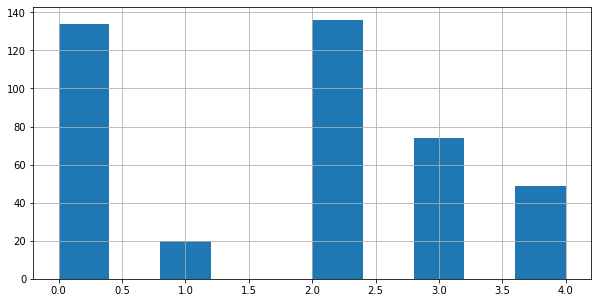

In [8]:
df['level'].hist(figsize = (10, 5))

In [9]:
df.pivot_table(index='level', aggfunc=len)

,path
level,
0,134
1,20
2,136
3,74
4,49


In [10]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

In [11]:
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

83

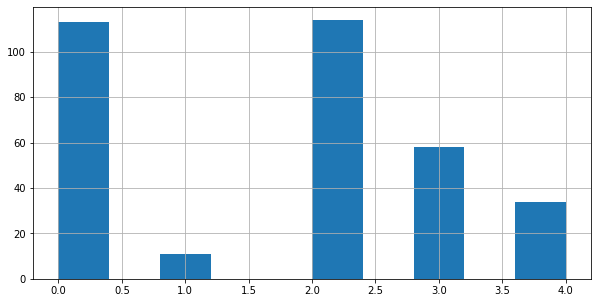

In [12]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [13]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,113
1,11
2,114
3,58
4,34


New Data Size: 570 Old Size: 330


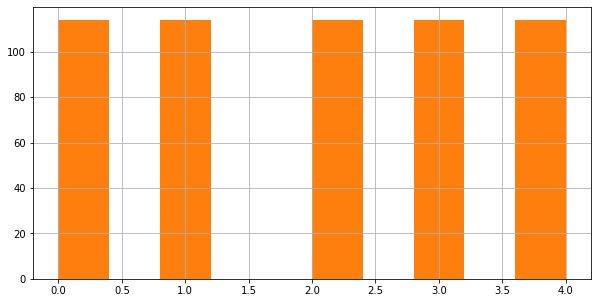

In [14]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [15]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)
print(df)

                                                                                                  path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_344.jpg      3
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_073.jpg      2
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_070.jpg      4
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_302.jpg      1
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_219.jpg      0
..                                                                                                 ...    ...
33   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_079.jpg      1
31   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_138.jpg      0
308  /cont

In [16]:
im = Image.open(train_df['path'][1])
width, height = im.size
# im.show
# print(width,height)

In [17]:
bs = 16 #smaller batch size is better for training, but may take longer
sz=224
print(len(train_df))
print(len(val_df))
print(len(df))

570
83
653


In [18]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [19]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
 
data = ImageDataBunch.from_df(path = '/', df = df, ds_tfms = tfms, size = sz, valid_pct = (len(val_df) / len(df)), bs = bs)
data = data.normalize(imagenet_stats)
print(data)

ImageDataBunch;

Train: LabelList (570 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,2,4,1,0
Path: /;

Valid: LabelList (83 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,0,3,2,3
Path: /;

Test: None


[0, 1, 2, 3, 4]


(5, 5)

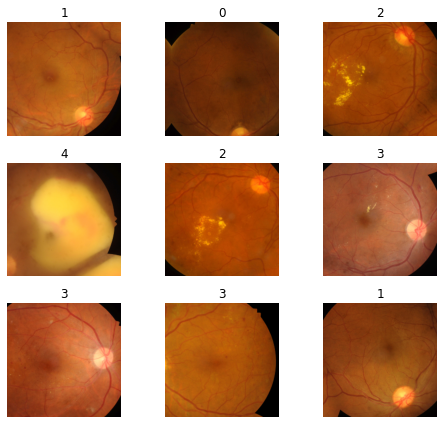

In [20]:
data.show_batch(rows=3, figsize=(7,6))

print(data.classes)
len(data.classes),data.c

#Transfer Learning (EfficientNet)

In [21]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat.cpu(),1), y.cpu(), weights='quadratic'),device='cuda:0')

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3., reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt)**self.gamma) * CE_loss
        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()

In [23]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=3f54024752e7253f05f97604394f381ffa6d86647f6ceb3aec526b6d9375a557
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [24]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')
model._fc = nn.Linear(model._fc.in_features, 5)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


In [25]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [26]:
import torchvision
# learn_efficient = Learner(data, model, metrics = [accuracy,quadratic_kappa])
learn_efficient = Learner(data, model,
                loss_func=FocalLoss(),
                metrics=[accuracy, quadratic_kappa],
                callback_fns=[BnFreeze]
               )

In [27]:
learn_efficient.split( lambda m: (model._conv_head,) )

Learner(data=ImageDataBunch;

Train: LabelList (570 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,2,4,1,0
Path: /;

Valid: LabelList (83 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,0,3,2,3
Path: /;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.0100000000

In [28]:
learn_efficient.freeze()

In [29]:
# learn_efficient.lr_find(start_lr=1e-5, end_lr=1e1, wd=5e-3)
# learn_efficient.recorder.plot(suggestion=True)

In [30]:
learn_efficient.fit_one_cycle(4, max_lr=3e-3, pct_start=0.1, div_factor=10, final_div=30, wd=5e-3, moms=(0.9, 0.8))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,0.570730,1.089916,0.253012,0.210552,03:26
1,0.422926,0.967793,0.337349,0.404704,02:55
2,0.375853,0.467455,0.457831,0.713840,02:57
3,0.326598,0.360559,0.614458,0.764221,02:54


In [31]:
learn_efficient.export('/content/drive/MyDrive/IDRid/Models/stage-1.pkl')

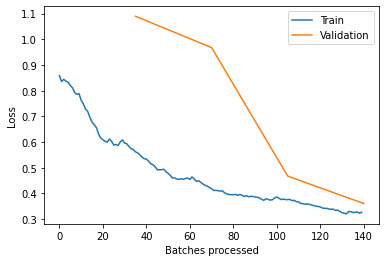

In [32]:
learn_efficient.recorder.plot_losses()

In [33]:
learn_efficient.unfreeze()

In [34]:
learn_efficient.fit_one_cycle(4, max_lr=slice(1e-4, 1e-3), div_factor=50, final_div=100, wd=1e-3, moms=(0.9, 0.8))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,0.252098,0.308355,0.650602,0.767158,02:59
1,0.249006,0.200401,0.686747,0.807124,02:55
2,0.211153,0.146960,0.843373,0.848517,02:57
3,0.178149,0.150413,0.843373,0.848517,02:56


In [35]:
learn_efficient.export('/content/drive/MyDrive/IDRid/Models/stage-2.pkl')

In [36]:
# train all layers
# learn_efficient.fit_one_cycle(cyc_len=15, max_lr=slice(1e-4, 1e-3), pct_start=0, final_div=1000, wd=1e-3, moms=(0.9, 0.8)) # warm restart: pct_start=0

In [37]:
learn_efficient.export('/content/drive/MyDrive/IDRid/Models/export.pkl')

In [38]:
# learn_efficient.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

In [39]:
# learn_efficient.recorder.plot_losses()

In [40]:
# learn_efficient.save('stage-2-224')

In [41]:
# learn_efficient.save('stage-2-448')

#Progressive Resizing

In [42]:
dataNew = ImageDataBunch.from_df(path = '/', df = df, ds_tfms = tfms, size = sz * 2, valid_pct = (len(val_df) / len(df)), bs = 4)
dataNew = dataNew.normalize(imagenet_stats)

In [43]:
learn_efficient.data = dataNew
dataNew.train_ds[0][0].shape

torch.Size([3, 448, 448])

In [44]:
learn_efficient.freeze()

In [45]:
learn_efficient.fit_one_cycle(4, max_lr=3e-3, pct_start=0.1, div_factor=10, final_div=30, wd=5e-3, moms=(0.9, 0.8))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,0.539092,0.512376,0.566265,0.637528,03:26
1,0.421791,0.752382,0.542169,0.692044,03:25
2,0.349848,0.292858,0.686747,0.712720,03:28
3,0.290742,0.254148,0.722892,0.737787,03:27


In [46]:
learn_efficient.unfreeze()

In [47]:
learn_efficient.fit_one_cycle(4, max_lr=slice(1e-4, 1e-3), div_factor=50, final_div=100, wd=1e-3, moms=(0.9, 0.8))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,0.285674,0.209060,0.771084,0.765675,03:30
1,0.328869,0.201031,0.698795,0.740808,03:30
2,0.222230,0.154936,0.783133,0.771677,03:31
3,0.179837,0.145062,0.783133,0.796350,03:34


In [48]:
learn_efficient.export('/content/drive/MyDrive/IDRid/Models/export.pkl')

#Checking Results

In [49]:
# learn_efficient = load_learner('/content/drive/MyDrive/IDRid/Models')

In [50]:
# interp = ClassificationInterpretation.from_learner(learn_efficient)

# # losses,idxs = interp.top_losses()

# len(data.valid_ds)==len(losses)==len(idxs)

In [51]:
# interp.plot_top_losses(9, figsize=(15,11))

In [52]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Testing Data

In [53]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['path'] = test_images_location + '/' + test_df['Image name'] + ".jpg"
test_df_['level'] = test_df['Retinopathy grade']
test_df = test_df_

print(test_df)

                                                                                                 path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_001.jpg      4
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_002.jpg      4
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_003.jpg      4
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_004.jpg      4
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_005.jpg      4
..                                                                                                ...    ...
98   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_099.jpg      0
99   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_100.jpg      2
100  /content/drive

In [54]:
# Create a test set to pass to our learner
test = (ImageList.from_df(path='/', df=test_df))
learn_efficient.data.add_test(test)

In [55]:
# Get predictions
preds1, l1 = learn_efficient.get_preds(DatasetType.Test)
preds2, l2 = learn_efficient.TTA(ds_type=DatasetType.Test)

In [56]:
preds1

tensor([[-8.2376e-01, -3.4990e+00, -1.3611e-01,  9.5223e-01,  2.9474e+00],
        [ 1.1611e+00, -2.8573e+00,  9.7250e-01, -1.2608e+00, -2.7529e-01],
        [ 6.3294e-03, -1.4533e+00,  4.1349e-01, -8.7470e-01,  1.1050e-01],
        [ 6.1783e-01, -9.7194e-01, -1.4799e+00, -1.7256e-01,  8.3760e-01],
        [ 1.4768e+00, -1.1445e-01,  8.2277e-01, -7.4895e-02, -6.1099e-01],
        [-1.7699e+00, -4.6706e+00,  3.4195e-01,  5.6319e-01, -4.6948e-01],
        [-2.2951e+00, -4.9013e+00,  6.3904e-01,  1.7007e+00,  8.5633e-01],
        [-2.8636e+00, -1.6408e+00,  1.0103e+00,  8.8631e-01, -7.8617e-01],
        [-1.5267e+00, -2.6889e+00,  1.6254e+00,  5.6239e-01, -7.4797e-01],
        [-1.4222e+00, -3.5883e+00,  1.0257e+00,  1.7609e+00, -2.2513e+00],
        [ 3.2943e-01, -1.7228e+00,  1.6104e+00,  1.0430e+00, -2.4699e+00],
        [ 5.1589e-01,  1.2191e+00, -3.4855e-01, -2.1057e+00, -3.5759e+00],
        [-3.8041e+00, -3.1289e+00,  8.0512e-01,  2.0991e+00, -1.9717e-01],
        [-2.5021e+00, -2.

In [57]:
preds2

tensor([[-1.1261, -2.2408,  0.1635,  1.1997,  2.6235],
        [ 0.9742, -1.9101,  0.8707, -0.5616, -0.0553],
        [ 0.3223, -0.8649,  0.4918, -1.0817,  0.4373],
        [ 0.9979,  0.1107, -1.0961, -0.2394,  0.7109],
        [ 1.2999, -0.0127,  0.8308, -0.1346, -0.2501],
        [-1.3103, -2.4767,  0.1735,  0.7415,  0.3521],
        [-1.6783, -3.2114,  0.7338,  1.5200,  0.7176],
        [-2.5399, -1.0348,  1.2179,  1.0674, -0.3526],
        [-1.9010, -2.6739,  1.5470,  0.9616, -0.8909],
        [-0.6656, -1.5041,  0.7575,  1.0119, -1.6091],
        [-0.0979, -1.6650,  1.7801,  1.2075, -1.8773],
        [ 0.7618,  1.2380,  0.1942, -1.4240, -2.6805],
        [-3.2803, -2.0408,  1.0499,  1.8790, -0.2708],
        [-2.2569, -2.4007,  1.2991,  0.9186,  1.2113],
        [-2.7823, -2.7973,  1.2872,  1.1623,  0.5744],
        [-2.4308, -2.4704,  0.6646,  1.0804,  2.3331],
        [-3.1147, -3.9910,  1.3847,  1.3313,  1.0204],
        [-2.2870, -1.0920,  0.5903,  0.8594, -0.2234],
        [-

In [58]:
preds1 = np.array(preds1)
preds2 = np.array(preds2)
print("preds1", preds1.shape)
print("preds2", preds2.shape)

preds1 (103, 5)
preds2 (103, 5)


In [59]:
preds1 = np.argmax(preds1, axis = 1)
preds2 = np.argmax(preds2, axis = 1)
print("preds1", preds1.shape)
print("preds2", preds2.shape)

preds1 (103,)
preds2 (103,)


In [60]:
labels = test_df['level']
labels.shape

(103,)

In [61]:
preds1

array([4, 0, 2, 4, ..., 2, 1, 2, 0])

In [62]:
preds2

array([4, 0, 2, 0, ..., 2, 1, 2, 0])

In [63]:
from sklearn.metrics import accuracy_score
print("preds1 => accuracy:", accuracy_score(labels, preds1))
print("preds2(with TTA) => accuracy:", accuracy_score(labels, preds2))

preds1 => accuracy: 0.5533980582524272
preds2(with TTA) => accuracy: 0.5728155339805825


In [64]:
from sklearn.metrics import cohen_kappa_score
print("preds1 => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds1, weights = "quadratic"));
print("preds2(with TTA) => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds2, weights = "quadratic"));

preds1 => quadratic_weighted_kappa: 0.685343500603879
preds2(with TTA) => quadratic_weighted_kappa: 0.6303015504822366


preds1 => Confusion Matrix
[[24  6  4  0  0]
 [ 2  2  1  0  0]
 [ 5  2 17  5  3]
 [ 1  0  5  8  5]
 [ 2  0  3  2  6]]


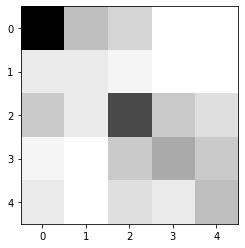

In [65]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds1) 
print("preds1 => Confusion Matrix")
print(cm)
plt.imshow(cm, cmap = 'binary')

preds2(with TTA) => Confusion Matrix
[[23  7  4  0  0]
 [ 2  2  1  0  0]
 [ 5  2 18  4  3]
 [ 2  0  4 11  2]
 [ 3  0  2  3  5]]


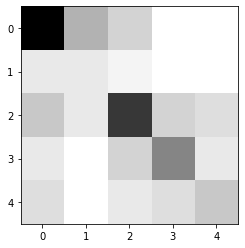

In [66]:
cm = confusion_matrix(labels, preds2) 
print("preds2(with TTA) => Confusion Matrix")
print(cm)
plt.imshow(cm, cmap = 'binary')

In [67]:
# TTA is easy - use .TTA() in place of .get_preds()
# preds_tta, labels_tta = learn.TTA(ds_type=DatasetType.Test)

In [68]:
# acc_tta = accuracy(preds_tta, labels_tta)
# print(acc_tta)

In [69]:
# test_images = []
# im_size = 224
# for image_path in df['path']:
#     img = cv2.imread(image_path)
#     img = cv2.resize(img, (im_size, im_size));
#     test_images.append(img);

In [70]:
# test_pred = learn.predict_array(test_imgs)
# test_pred = np.argmax(test_pred, axis=1)
# test_pred

In [71]:
# sample for finding quadratic weighted kappa
# from sklearn.metrics import cohen_kappa_score, confusion_matrix
# import numpy as np
# from time import time

# #dataset
# actuals = np.array([4, 4, 3, 4, 4, 0, 1, 1, 2, 1])
# preds   = np.array([0, 4, 1, 0, 4, 0, 1, 1, 2, 1])
# qwk = cohen_kappa_score(actuals, preds, weights="quadratic")
# print(qwk)